In [30]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Triple Junctions
In this notebook we discuss the approach to dealing with 3 fault elements meeting at a point aka a triple junction. In plate kinematics, we deal with triple junctions by imposing that the slip vector at the triple junction is a conserved vector quantity i.e., 
$\begin{equation}
\underline{s}_1 + \underline{s}_2 + \underline{s}_3 = 0
\end{equation}$

Note in the above equation the sign of the slip vector depends on the circulation and directions of the unit normal vectors to each fault element. Below we start by constructing a 3-fault triple junction. 

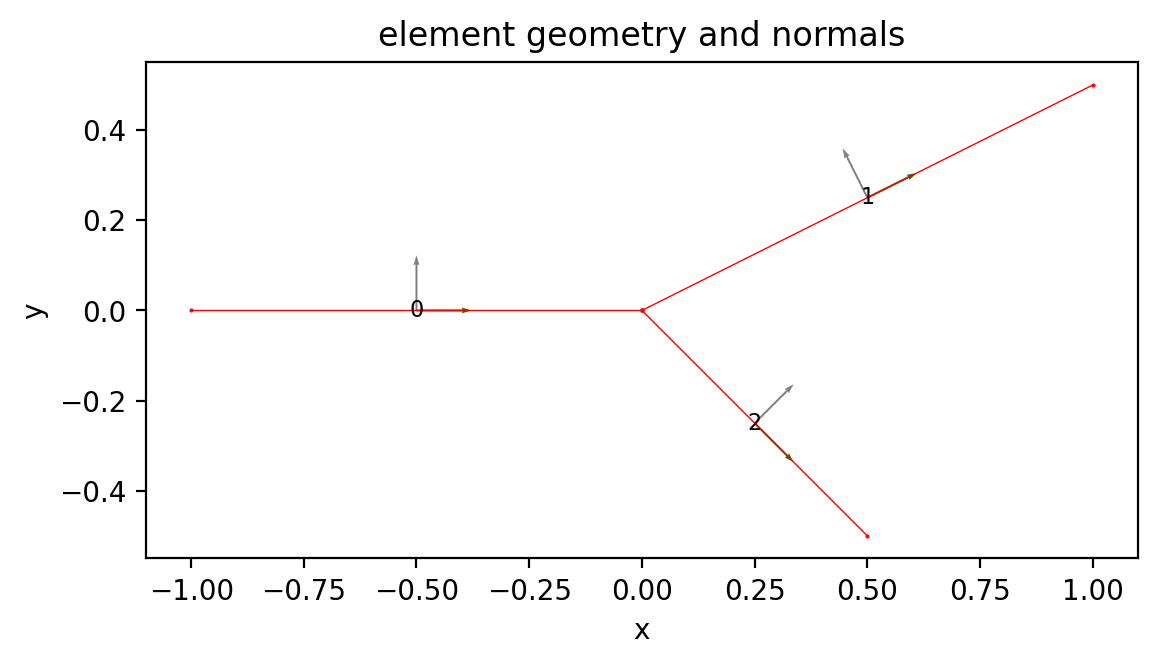

In [31]:
# Elastic parameters
mu = 1
nu = 0.25

# Triple junction geometry
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0])
els.x2 = np.array([0.0, 1.0, 0.5])
els.y1 = np.array([0.0, 0.0, 0.0])
els.y2 = np.array([0.0, 0.5, -0.5])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)


# Specify slip vector on all three elements
We specify the values of the slip vector here. These are important for the linear operator and boundary conditions that we need. 

In [32]:
slip_vector_x = np.array([1.0, 0.8, -0])
slip_vector_y = np.array([0.5, 0.5, -0])


# Get linear operators that will be used to build the linear operator

In [33]:
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, flag="node"
)
matrix_slip_mean, _ = bemcs.get_matrices_slip_slip_gradient(els, flag="mean")


# Linear operator and boundary conditions
For $N = 3$ elements, each having three nodes ($n_1$, $n_2$, and $n_3$), giving us have $18$ equations. The linear operator that contains these equations itself has 4 different types of equations:
- Slip values (specified as either nodal or mean values) for the central node ($n_2$) of every element
- Slip values for the open nodes ($n_1$ or $n_3$) is set to $0$. The open nodes in this system are $p_1(n_1)$, $p_2(n_3)$, and $p_3(n_3)$.

# Boundary condtions we're pretty sure of:
| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 1   | $p^x_1(n_1) = 0$     | element 1: $x$ slip at open node    |
| 2   | $p^y_1(n_1) = 0$     | element 1: $y$ slip at open node    |
| 3   | $p^x_1(n_2) = u^x_1$ | element 1: $x$ slip at central node |
| 4   | $p^y_1(n_2) = u^y_1$ | element 1: $y$ slip at central node |
| 5   | $p^x_2(n_3) = 0$     | element 2: $x$ slip at open node    |
| 6   | $p^y_2(n_3) = 0$     | element 2: $y$ slip at open node    |
| 7   | $p^x_2(n_2) = u^x_2$ | element 2: $x$ slip at central node |
| 8   | $p^y_2(n_2) = u^y_2$ | element 2: $y$ slip at central node |
| 9   | $p^x_3(n_3) = 0$     | element 3: $x$ slip at open node    |
| 10  | $p^y_3(n_3) = 0$     | element 3: $y$ slip at open node    |
| 11  | $p^x_3(n_2) = u^x_3$ | element 3: $x$ slip at central node |
| 12  | $p^y_3(n_2) = u^y_3$ | element 3: $y$ slip at central node |

# We need six more equations and there seem to be several options


# Case A
- Continuity of slip at a triple junction 
- Smoothness of slip between any 2 elements that share a common node (this is questionable)

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $\partial p^x_1(n_3) / \partial x - \partial p^x_2(n_1) / \partial x = 0$ | elements 1, 2: continuity of $x$ slip gradient at a triple junction |
| 16  | $\partial p^y_1(n_3) / \partial y - \partial p^y_2(n_1) / \partial y = 0$ | elements 1, 2: continuity of $y$ slip gradient at a triple junction |
| 17  | $\partial p^x_1(n_3) / \partial x - \partial p^x_3(n_1) / \partial x = 0$ | elements 1, 3: continuity of $x$ slip gradient at a triple junction |
| 18  | $\partial p^y_1(n_3) / \partial y - \partial p^y_3(n_1) / \partial y = 0$ | elements 1, 3: continuity of $y$ slip gradient at a triple junction |

#### Pros:
- Non-singular

#### Cons:
- Stresses are not continuous at triple junction!!!

#### Notes:
- Does slip actually vary smoothly from element to element at the triple junction?  I'm asking this because the displacement as a function x figure looks non-smooth at the triple junction.  Also equation 15-18 cover the 1-2 and 1-3 smoothness case but what about the 2-3 case?  We could write the 2-3 case but I think you mentioned that this would be redundant?


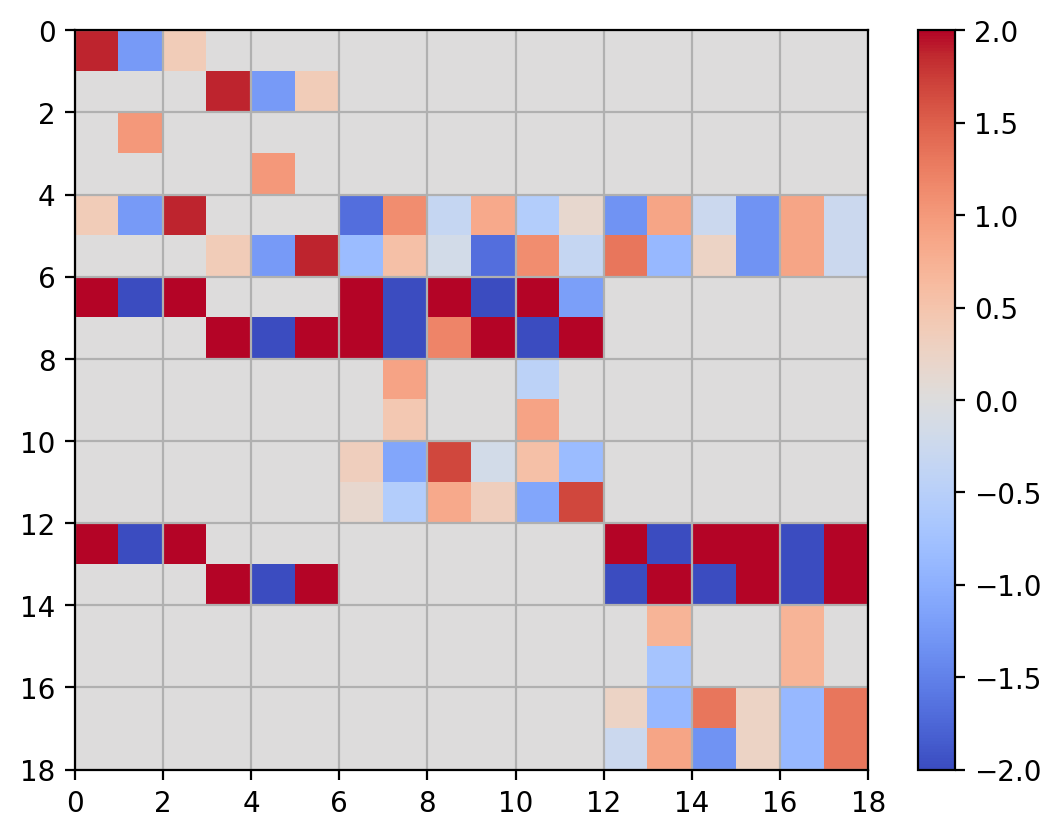

Linear operator condition number: 36.196845606429335


In [34]:
stride = 6
Nequations = stride * n_els
Nunknowns = stride * n_els
matrix_system = np.zeros((Nequations, Nunknowns))

BCvector = np.zeros((Nequations, 1))
BCvector[2::6] = slip_vector_x.reshape((-1, 1))
BCvector[3::6] = slip_vector_y.reshape((-1, 1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2, :] = matrix_slip[0:2:]  # first element open node
matrix_system[10:12, :] = matrix_slip[10:12:]  # second element open node
matrix_system[16:18, :] = matrix_slip[16:18, :]  # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6, :] = matrix_slip[2::6, :]  # x component
matrix_system[3::6, :] = matrix_slip[3::6, :]  # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
matrix_system[4, :] = (
    matrix_slip[4, :] - matrix_slip[6, :] - matrix_slip[12, :]
)  # x component
matrix_system[5, :] = (
    matrix_slip[5, :] - matrix_slip[7, :] - matrix_slip[13, :]
)  # y component

# smoothness (applied 2 elements at a time)
matrix_system[6, :] = matrix_slip_gradient[4, :] - matrix_slip_gradient[6, :]
matrix_system[7, :] = matrix_slip_gradient[5, :] - matrix_slip_gradient[7, :]
matrix_system[12, :] = matrix_slip_gradient[4, :] - matrix_slip_gradient[12, :]
matrix_system[13, :] = matrix_slip_gradient[5, :] - matrix_slip_gradient[13, :]

# plot design matrix
_, ax = plt.subplots()
pc = ax.pcolor(matrix_system, cmap="coolwarm", shading="flat")
ax.grid(which="both")
ax.invert_yaxis()
pc.set_clim(-2, 2)
plt.colorbar(pc)
plt.show()

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear operator condition number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]


#### Case A: Displacements and stresses
When I first plotted this, it looked like the slip smoothness condition does not completely remove the singularity at the triple junction. But after thinking about it some more, I am coming to realize that it is probably okay. The reason there are discontinuities in stress is because the traction vector is continuous at the triple junction, but that does not guarantee that stresses should be too.

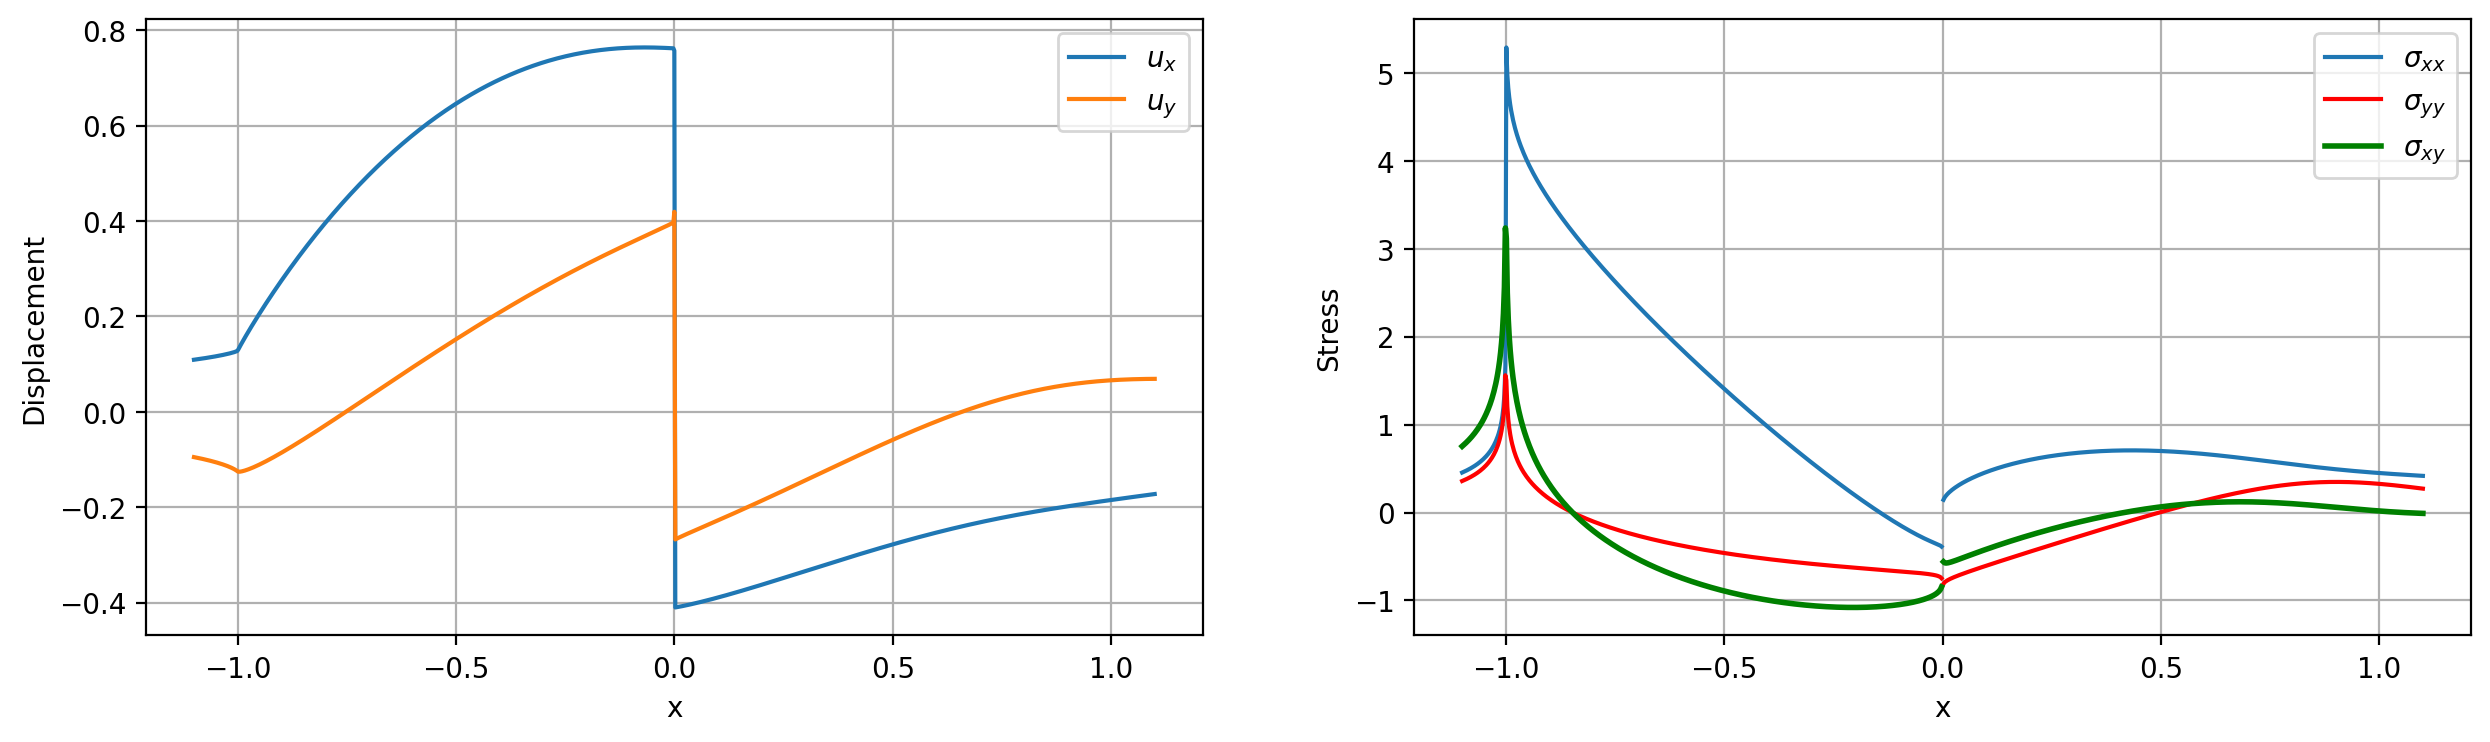

In [35]:
# Compute displacements along a line
x_obs = np.linspace(-1.1, 1.1, 1001).reshape(-1, 1)
y_obs = 1e-8 + x_obs * 0

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)

# Compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, "-", label="$u_x$")
plt.plot(x_obs, uy, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()


# Case B
- Continuity of slip at a triple junction using element by element pairing.  This is essentially what we do for the two element case and there is no direct notion of a triple junction in the math here.

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) = 0$     | elements 1, 2: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) = 0$     | elements 1, 2: continuity of $y$ slip at a triple junction   |
| 15  | $p^x_1(n_3) - p^x_3(n_1) = 0$     | elements 1, 3: continuity of $x$ slip at a triple junction   |
| 16  | $p^y_1(n_3) - p^y_3(n_1) = 0$     | elements 1, 3: continuity of $y$ slip at a triple junction   |
| 17  | $p^x_2(n_3) - p^x_3(n_1) = 0$     | elements 2, 3: continuity of $x$ slip at a triple junction   |
| 18  | $p^y_2(n_3) - p^y_3(n_1) = 0$     | elements 2, 3: continuity of $y$ slip at a triple junction   |


#### Pros:
Slip is continuous

#### Cons:
Singular stresses at the triple junction



# Case C
- Continuity of slip at a triple junction 
- Smoothness of slip between 2 selected elements that share the triple junction
- Set the slip gradient for the third element to 0

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $\partial p^x_1(n_3) / \partial x - \partial p^x_2(n_1) / \partial x - \partial p^x_3(n_1) / \partial x = 0$ | elements 1, 2, 3: continuity of $x$ slip gradient at a triple junction |
| 16  | $\partial p^y_1(n_3) / \partial y - \partial p^y_2(n_1) / \partial y - \partial p^y_3(n_1) / \partial y = 0$ | elements 1, 2, 3: continuity of $y$ slip gradient at a triple junction |
| 17  | $\partial p^x_3(n_1) / \partial x = 0$ or $ \partial p^x_2(n_1) / \partial x = 0$ | elements 2 or 3: continuity of $x$ slip gradient at a triple junction |
| 18  | $\partial p^y_3(n_1) / \partial y = 0$ or $ \partial p^y_2(n_1) / \partial y = 0$ | elements 2 or 3: continuity of $y$ slip gradient at a triple junction |

#### Pros:
- Non-singular 
- Continuous displacements and stresses!!! (### realization on 27th July 2023 - this is not true. It was only true because we were looking at co-planar elements)

#### Cons:
- Bizarre extra boundary condition
- Extra boundary condtion has to be on elements 2 or 3 but not element 1.  If BC is on element 1, need to change the order of the slip conservation equation


Linear Operator Condition Number: 45.749364892623724


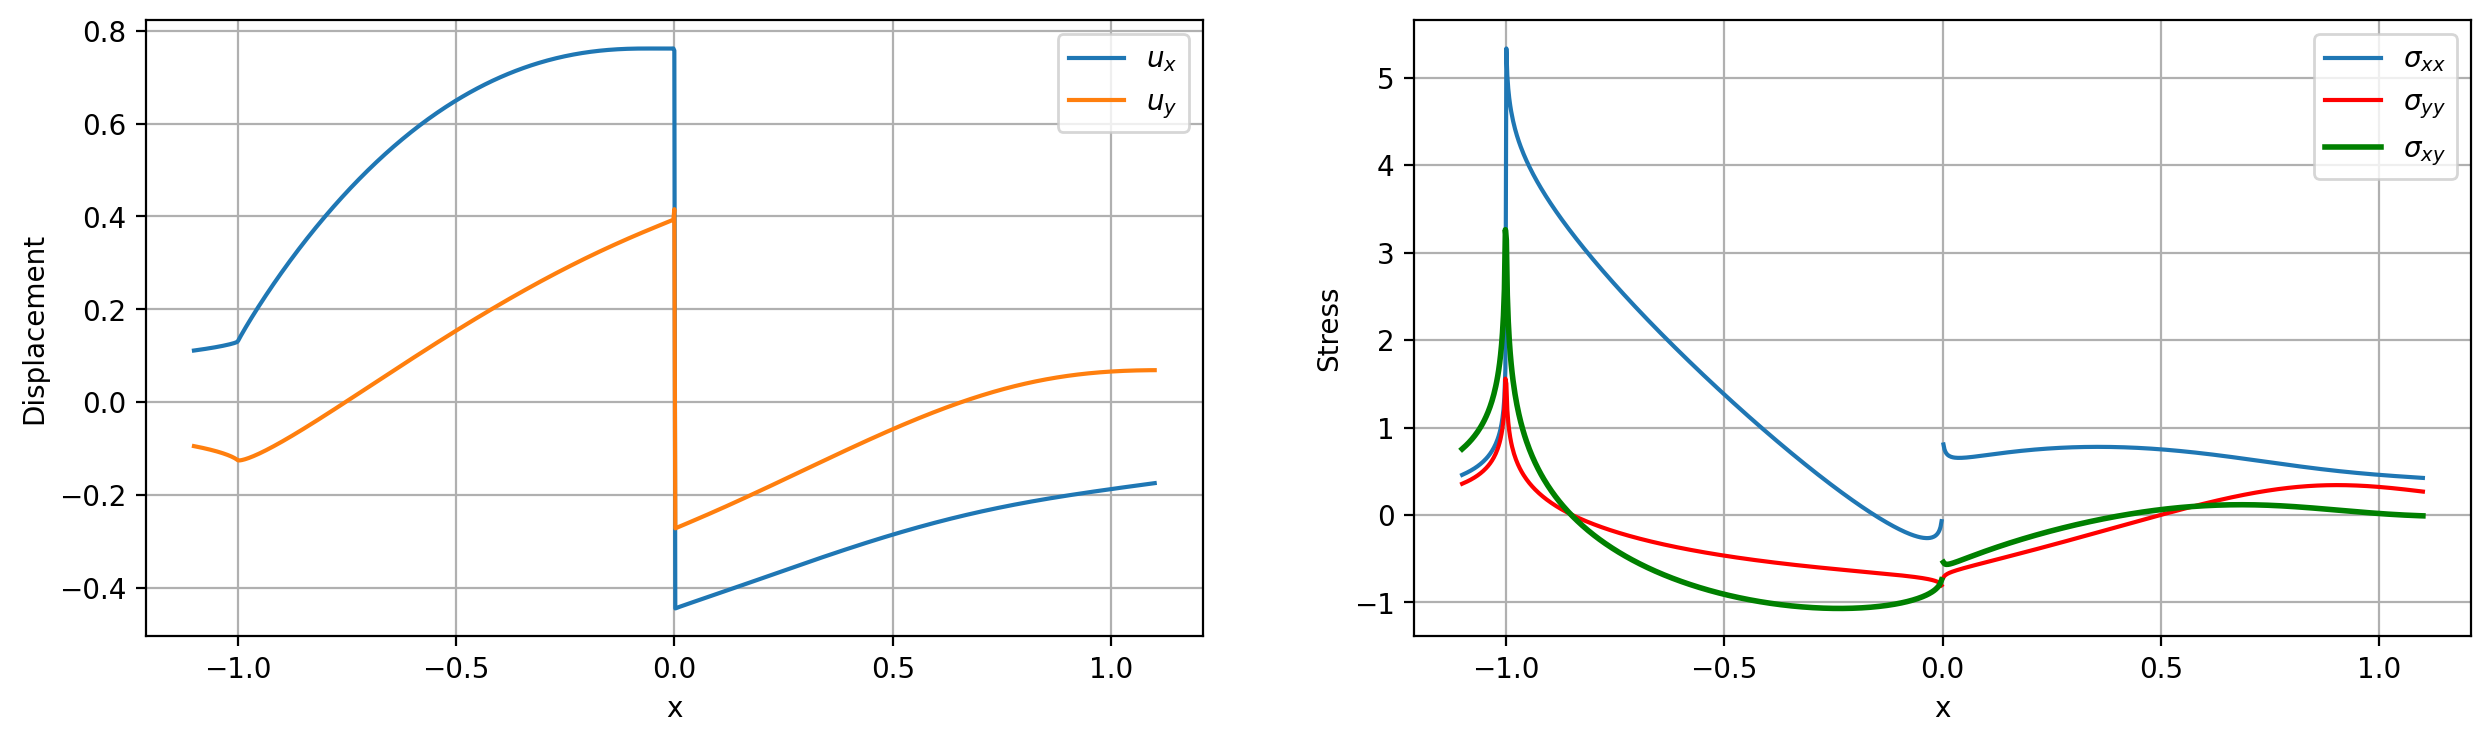

In [36]:
matrix_system = np.zeros((Nequations, Nunknowns))

BCvector = np.zeros((Nequations, 1))
BCvector[2::6] = slip_vector_x.reshape((-1, 1))
BCvector[3::6] = slip_vector_y.reshape((-1, 1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2, :] = matrix_slip[0:2:]  # first element open node
matrix_system[10:12, :] = matrix_slip[10:12:]  # second element open node
matrix_system[16:18, :] = matrix_slip[16:18, :]  # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6, :] = matrix_slip[2::6, :]  # x component
matrix_system[3::6, :] = matrix_slip[3::6, :]  # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
matrix_system[4, :] = (
    matrix_slip[4, :] - matrix_slip[6, :] - matrix_slip[12, :]
)  # x component
matrix_system[5, :] = (
    matrix_slip[5, :] - matrix_slip[7, :] - matrix_slip[13, :]
)  # y component

# triple junction equation of smoothness
matrix_system[6, :] = (
    matrix_slip_gradient[4, :]
    - matrix_slip_gradient[6, :]
    - matrix_slip_gradient[12, :]
)
matrix_system[7, :] = (
    matrix_slip_gradient[5, :]
    - matrix_slip_gradient[7, :]
    - matrix_slip_gradient[13, :]
)

# testing additional constraints
# matrix_system[12,:] = matrix_slipgradient[6,:]
# matrix_system[13,:] = matrix_slipgradient[7,:]
matrix_system[12, :] = matrix_slip_gradient[12, :]
matrix_system[13, :] = matrix_slip_gradient[13, :]

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, "-", label="$u_x$")
plt.plot(x_obs, uy, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()


# Case D

- Continuity of slip at a triple junction 
- Smoothness of slip implemented as continuity of the Jacobian of slip instead of the directional derivative of slip 
 
The Jacobian of slip in terms of slip gradients in the fault-centric coordinates $\frac{\partial s_s}{\partial \zeta}, \frac{\partial s_n}{\partial \zeta}$ is 

$\begin{aligned} R^T (\nabla\underline{s}) R & = \begin{bmatrix} d_x & n_x \\ d_z & n_z \end{bmatrix}\begin{bmatrix} \frac{\partial s_s}{\partial \zeta} & 0 \\ \frac{\partial s_n}{\partial \zeta} & 0\end{bmatrix}\begin{bmatrix} d_x & d_z \\ n_x & n_z \end{bmatrix} \\
& = \begin{bmatrix} \frac{\partial s_s}{\partial\zeta}d_x^2 + \frac{\partial s_n}{\partial\zeta}d_x n_x & 
\frac{\partial s_s}{\partial\zeta}d_x d_z + \frac{\partial s_n}{\partial\zeta}n_x d_z \\
\frac{\partial s_s}{\partial\zeta}d_x d_z + \frac{\partial s_n}{\partial\zeta}n_z d_x & 
\frac{\partial s_s}{\partial\zeta}d_z^2 + \frac{\partial s_n}{\partial\zeta}n_z d_z
\end{bmatrix}\end{aligned}$

where $d_x,d_z$ is the unit vector for the shear direction and $n_x,n_z$ is in the normal direction.

| bc# | expression           | meaning                             |
|-----|----------------------|-------------------------------------|
| 13  | $p^x_1(n_3) - p^x_2(n_1) - p^x_3(n_1) = 0$     | elements 1, 2, 3: continuity of $x$ slip at a triple junction   |
| 14  | $p^y_1(n_3) - p^y_2(n_1) - p^y_3(n_1) = 0$     | elements 1, 2, 3: continuity of $y$ slip at a triple junction   |
| 15  | $(\nabla s)^{xx}_1(n_3) - (\nabla s)^{xx}_2(n_1) - (\nabla s)^{xx}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $xx$ slip gradient at a triple junction |
| 16  | $(\nabla s)^{xy}_1(n_3) - (\nabla s)^{xy}_2(n_1) - (\nabla s)^{xy}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $xy$ slip gradient at a triple junction |
| 17  | $(\nabla s)^{yx}_1(n_3) - (\nabla s)^{yx}_2(n_1) - (\nabla s)^{yx}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $yx$ slip gradient at a triple junction |
| 18  | $(\nabla s)^{yy}_1(n_3) - (\nabla s)^{yy}_2(n_1) - (\nabla s)^{yy}_3(n_1) = 0$ | elements 1, 2, 3: continuity of $yy$ slip gradient at a triple junction |

#### Pros:
- 

#### Cons:
- 


In [ ]:
matrix_system = np.zeros((Nequations, Nunknowns))

BCvector = np.zeros((Nequations, 1))
BCvector[2::6] = slip_vector_x.reshape((-1, 1))
BCvector[3::6] = slip_vector_y.reshape((-1, 1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2, :] = matrix_slip[0:2:]  # first element open node
matrix_system[10:12, :] = matrix_slip[10:12:]  # second element open node
matrix_system[16:18, :] = matrix_slip[16:18, :]  # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6, :] = matrix_slip[2::6, :]  # x component
matrix_system[3::6, :] = matrix_slip[3::6, :]  # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# triple junction equation of continuity
matrix_system[4, :] = (
    matrix_slip[4, :] - matrix_slip[6, :] - matrix_slip[12, :]
)  # x component
matrix_system[5, :] = (
    matrix_slip[5, :] - matrix_slip[7, :] - matrix_slip[13, :]
)  # y component

# triple junction equation of smoothness
matrix_system[6, :] = (
    matrix_slip_gradient[4, :]
    - matrix_slip_gradient[6, :]
    - matrix_slip_gradient[12, :]
)
matrix_system[7, :] = (
    matrix_slip_gradient[5, :]
    - matrix_slip_gradient[7, :]
    - matrix_slip_gradient[13, :]
)

# testing additional constraints
# matrix_system[12,:] = matrix_slipgradient[6,:]
# matrix_system[13,:] = matrix_slipgradient[7,:]
matrix_system[12, :] = matrix_slip_gradient[12, :]
matrix_system[13, :] = matrix_slip_gradient[13, :]

# Solve the system
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ quadratic_coefs_s + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ quadratic_coefs_s + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, "-", label="$u_x$")
plt.plot(x_obs, uy, "-", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx, "-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.show()
